**Author:** Enrique Ruiz de Almirón Da Silva

### Black–Scholes–Merton Model (Intuitive Explanation)

The Black–Scholes–Merton (BSM) model estimates the fair theoretical value of a financial option. It’s one of the most fundamental pricing models in finance, widely used to understand how much an option should be worth given certain market conditions.

#### 1. The Idea Behind the Model

An option gives you the right (but not the obligation) to buy or sell an asset at a specific price (the strike price, 
𝐾
K) on or before a given date.

- A call option lets you buy the asset.
- A put option lets you sell it.

The BSM model focuses on European options, which can only be exercised at expiration (unlike American options, explained below).

The model’s main goal is to calculate what that option should be worth today, based on:

 - Underlying price (S)
 - Strike price (k)
 - Time to expiration (T)
 - Risk free Rate (r)
 - Volatility (𝜎)

#### 2. European vs. American Options


| Feature         | European Option        | American Option                                               |
| --------------- | ---------------------- | ------------------------------------------------------------- |
| Exercise time   | Only **at expiration** | **Any time** before or at expiration                          |
| Simplicity      | Easier to model        | More complex due to early exercise                            |
| BSM applicable? | **Yes**                | Not directly (requires binomial or finite-difference methods) |


#### 3. The Core Intuition

The Black–Scholes model assumes:

- The stock price follows a lognormal distribution (it can’t go below zero, and large upward moves are possible but less likely).

- There are no arbitrage opportunities (no risk-free profit).

- The market is frictionless (no transaction costs, perfect liquidity).

- You can continuously hedge risk by adjusting your position in the underlying asset.

The central idea:
By combining an option position with a certain amount of the underlying asset, you can create a risk-free portfolio.
If it’s risk-free, it must grow at the risk-free rate 
𝑟.
This insight allows us to derive a partial differential equation, which leads to the closed-form Black–Scholes formula.

# Libraries

In [1]:
import math 
from scipy.stats import norm
import numpy as np 
import pandas as pd

## Define the variables 

In [2]:
# === Black-Scholes Base Parameters ===
r = 0.1      # Risk-free rate
T = 0.5      # Time to maturity (years)
sigma = 0.2  # Volatility
S = 100
# Base moneyness scenarios
scenarios = {
    "OTM": { "K": 120},   # Out of the money
    "ATM": {"K": 100},   # At the money
    "ITM": {"K": 80}    # In the money
}

## Define Functions

$$
\textbf{The Black–Scholes–Merton Model:}
$$

$$
\begin{aligned}
d_1 &= \frac{\ln\left(\frac{S}{K}\right) + \left(r + \frac{1}{2}\sigma^2\right)T}{\sigma \sqrt{T}} \\[10pt]
d_2 &= d_1 - \sigma \sqrt{T} \\[10pt]
C &= S\,N(d_1) - K\,e^{-rT}N(d_2) \\[10pt]
P &= K\,e^{-rT}N(-d_2) - S\,N(-d_1)
\end{aligned}
$$

$$
\text{where } 
N(x) = \text{CDF of the standard normal distribution.}
$$


- d1      represents the standardized distance between the current stock price and the strike, adjusted for risk and volatility. It can be interpreted as the probability-weighted likelihood of finishing in the money, accounting for expected growth.


- d2      shifted down by volatility — it’s the risk-adjusted probability that the option will expire in the money.

In [3]:
def black_scholes_price(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call = S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    put  = K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
    return call, put, d1, d2

$$
\textbf{The Greeks in the Black–Scholes–Merton Model:}
$$

$$
\begin{aligned}
\textbf{Delta:}\quad & \Delta_{\text{call}} = N(d_1), \qquad \Delta_{\text{put}} = N(d_1) - 1 \\[8pt]
\textbf{Gamma:}\quad & \Gamma = \frac{N'(d_1)}{S \sigma \sqrt{T}} \\[8pt]
\textbf{Vega:}\quad & \nu = S N'(d_1) \sqrt{T} \\[8pt]
\textbf{Theta:}\quad & 
\Theta_{\text{call}} = 
\frac{-S N'(d_1)\sigma}{2\sqrt{T}}
- r K e^{-rT} N(d_2) \\[3pt]
& 
\Theta_{\text{put}} = 
\frac{-S N'(d_1)\sigma}{2\sqrt{T}}
+ r K e^{-rT} N(-d_2) \\[8pt]
\textbf{Rho:}\quad &
\rho_{\text{call}} = K T e^{-rT} N(d_2), \qquad
\rho_{\text{put}} = -K T e^{-rT} N(-d_2)
\end{aligned}
$$

$$
N(x) = \text{CDF of the standard normal distribution}, 
\qquad 
N'(x) = \text{PDF of the standard normal distribution.}
$$


In [4]:
def black_scholes_greeks(S, K, T, r, sigma, option='call'):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    pdf = norm.pdf(d1)
    
    if option == 'call':
        delta = norm.cdf(d1)
        theta = -(S * pdf * sigma) / (2*np.sqrt(T)) - r*K*np.exp(-r*T)*norm.cdf(d2)
        rho   = K*T*np.exp(-r*T)*norm.cdf(d2)
    else:
        delta = norm.cdf(d1) - 1
        theta = -(S * pdf * sigma) / (2*np.sqrt(T)) + r*K*np.exp(-r*T)*norm.cdf(-d2)
        rho   = -K*T*np.exp(-r*T)*norm.cdf(-d2)
    
    gamma = pdf / (S * sigma * np.sqrt(T))
    vega  = S * pdf * np.sqrt(T)
    
    return {
        "Delta": delta,
        "Gamma": gamma,
        "Vega": vega,
        "Theta": theta,
        "Rho": rho
    }

In [5]:
results = {}

for label, params in scenarios.items():
    K = params["K"]
    call, put, _, _ = black_scholes_price(S, K, T, r, sigma)
    greeks = black_scholes_greeks(S, K, T, r, sigma)
    results[label] = {"Call": call, "Put": put, **greeks}
df = pd.DataFrame(results).T
df = df.round({
    "Call": 2, "Put": 2,
    "Delta": 4, "Gamma": 5, "Vega": 4,
    "Theta": 4, "Rho": 4
})
df.style.set_caption("Black–Scholes Prices and Greeks across Moneyness")

,Call,Put,Delta,Gamma,Vega,Theta,Rho
OTM,1.420000,15.570000,0.193500,0.019410,19.406200,-5.674700,8.967400
ATM,8.280000,3.400000,0.664300,0.025780,25.781500,-10.971700,29.076800
ITM,24.030000,0.130000,0.977400,0.003800,3.801500,-8.131200,36.854700


## 1. In-the-Money (ITM) Call

- Exhibits high Delta (0.98) and low Gamma (0.004). The price of the call moves almost one-for-one with the underlying, behaving similarly to holding the stock itself.
- Vega and Gamma are minimal since volatility and small price fluctuations have little impact — the option is almost certain to finish in the money.
- Theta remains negative but moderate, reflecting limited time value left to decay.
- Rho is highest, as the discounted strike (K·e⁻ʳᵀ) dominates the valuation when intrinsic value is large.

Interpretation: An ITM call behaves as a leveraged long position with limited curvature — low optionality but strong directional exposure.

## 2. At-the-Money (ATM) Call

- Shows the highest Gamma and Vega, making it the most sensitive to both underlying price movements and volatility changes.
- Delta (0.66) reflects a roughly 50–60% probability of finishing in the money, highlighting maximum uncertainty.
- Theta is most negative — the option loses time value fastest because every passing day reduces uncertainty around exercise.
- Rho is moderate but increasing, since both the option’s time value and discounting matter.

Interpretation: The ATM region concentrates convexity and volatility risk — this is where traders face the greatest re-hedging costs and volatility exposure.

## 3. Out-of-the-Money (OTM) Call

- Characterized by low Delta (0.19) and low Gamma (0.019) — the option is cheap but largely insensitive to small price movements.
- Vega is still notable, as volatility changes can shift the probability of finishing ITM.
- Theta is less negative than ATM — OTM options decay more slowly in absolute terms because they hold limited time value.
- Rho is lowest, since most of the price is driven by volatility rather than discounting effects.

Interpretation: The OTM call behaves like a low-cost lottery ticket — limited directional sensitivity, high convexity potential, but low immediate responsiveness.

OTM: dominated by volatility and convexity.

ATM: dominated by uncertainty and time decay.

ITM: dominated by directional exposure and interest-rate effects.

## GREEKS BEHAVIOUR ACROSS MONEYNESS

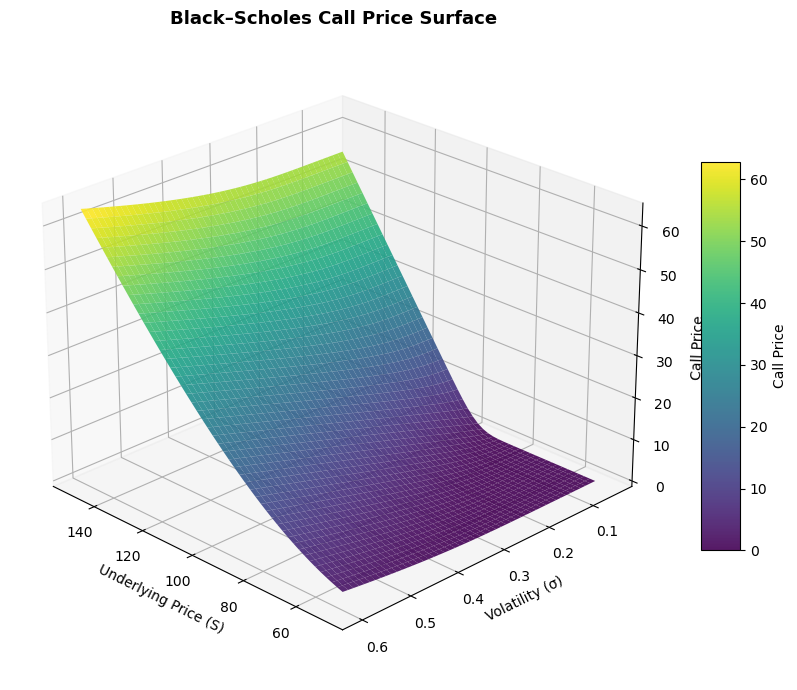

In [6]:
# ============================================
# 3D SURFACE: Call Price vs Underlying Price (S) and Volatility (σ)
# ============================================

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Base parameters (use same ones you defined earlier)
K = 100     # strike price
T = 1.0     # time to maturity (1 year)
r = 0.05    # risk-free rate

# Create grid of S and σ
S_values = np.linspace(50, 150, 50)
sigma_values = np.linspace(0.05, 0.6, 50)
S_grid, sigma_grid = np.meshgrid(S_values, sigma_values)

# Compute call prices for each (S, σ)
price_grid = np.zeros_like(S_grid)
for i in range(len(S_values)):
    for j in range(len(sigma_values)):
        call_price, _, _, _ = black_scholes_price(S_values[i], K, T, r, sigma_values[j])
        price_grid[j, i] = call_price

# Plot surface
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(S_grid, sigma_grid, price_grid, cmap='viridis', edgecolor='none', alpha=0.9)

ax.set_title('Black–Scholes Call Price Surface', fontsize=13, fontweight='bold')
ax.set_xlabel('Underlying Price (S)')
ax.set_ylabel('Volatility (σ)')
ax.set_zlabel('Call Price')
ax.view_init(elev=25, azim=135)  # Adjust angle for a cleaner view

fig.colorbar(surf, shrink=0.6, aspect=10, label='Call Price')
plt.tight_layout()
plt.show()

### Interpretation
The surface illustrates how option value increases with both the underlying price (S) and volatility (σ).  
- As **S** rises, the option becomes more likely to finish in the money, raising its intrinsic value.  
- As **σ** rises, uncertainty increases, boosting the option’s time value.  
This convex surface visualizes the dual sensitivity of options to price and volatility risk — the foundation of volatility trading and hedging strategies.


## Delta vs Underlying Price across Moneyness

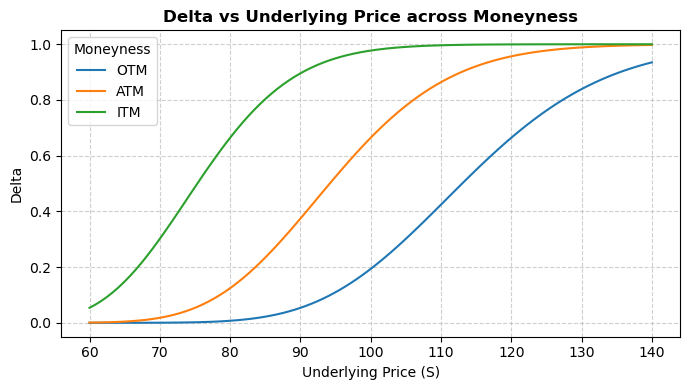

In [6]:
import matplotlib.pyplot as plt
import numpy as np

S_range = np.linspace(60, 140, 100)
plt.figure(figsize=(7,4))

for label, params in scenarios.items():
    K = params["K"]
    delta_vals = [black_scholes_greeks(S, K, T, r, sigma)["Delta"] for S in S_range]
    plt.plot(S_range, delta_vals, label=label)

plt.title("Delta vs Underlying Price across Moneyness", fontsize=12, fontweight='bold')
plt.xlabel("Underlying Price (S)")
plt.ylabel("Delta")
plt.legend(title="Moneyness")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Delta transitions faster when the option is near the strike, reflecting its non-linear payoff structure.
The ITM call already behaves like the underlying asset (Delta close to 1), while the OTM call is nearly insensitive (Delta ≈ 0).
At-the-money options exhibit the highest reactivity — they are most exposed to changes in the underlying.

From a hedging perspective, these curves illustrate the degree of exposure a trader must neutralize:

- ITM calls: nearly full Delta hedging required.
- OTM calls: minimal hedge impact.
- ATM calls: most dynamic, since small moves in S shift Delta rapidly.

## Gamma 

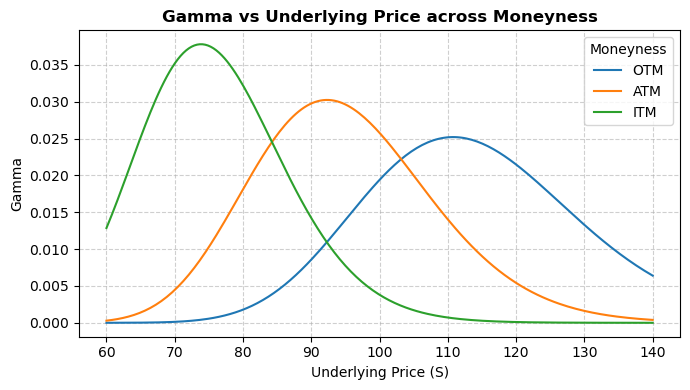

In [7]:
# === GAMMA vs UNDERLYING PRICE ACROSS MONEYNESS ===

S_range = np.linspace(60, 140, 200)

plt.figure(figsize=(7,4))

for label, params in scenarios.items():
    K = params["K"]
    gammas = [black_scholes_greeks(S, K, T, r, sigma, option='call')["Gamma"]
              for S in S_range]
    plt.plot(S_range, gammas, label=label)

plt.title("Gamma vs Underlying Price across Moneyness", fontsize=12, fontweight="bold")
plt.xlabel("Underlying Price (S)")
plt.ylabel("Gamma")
plt.legend(title="Moneyness")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Gamma peaks at-the-money, indicating that Delta changes most rapidly when the option is near its strike.
This reflects the region of highest convexity — small movements in the underlying cause large shifts in Delta.
As the option moves deep ITM or OTM, Gamma declines sharply: Delta becomes stable (near 1 or 0), and the option’s price behaves almost linearly.

In trading terms, this means hedging difficulty is greatest for ATM options — their Delta must be rebalanced frequently.

The three curves also shift horizontally with strike, aligning with their respective moneyness, which visually reinforces that Gamma is localized around the strike.

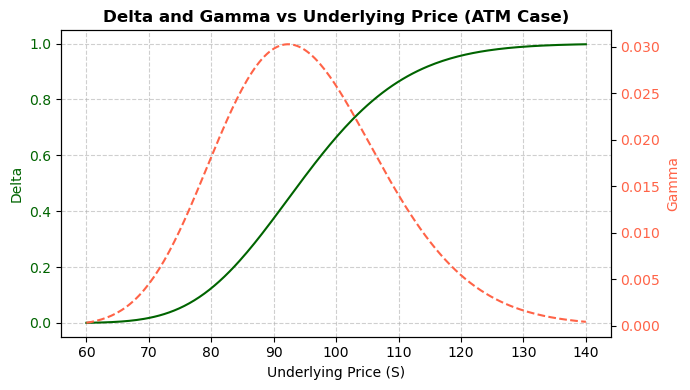

In [8]:
# === Combined Delta & Gamma Plot (ATM case) ===

S_range = np.linspace(60, 140, 200)
K = 100  # ATM case

deltas = [black_scholes_greeks(S, K, T, r, sigma, option='call')["Delta"] for S in S_range]
gammas = [black_scholes_greeks(S, K, T, r, sigma, option='call')["Gamma"] for S in S_range]

fig, ax1 = plt.subplots(figsize=(7,4))

# Delta on left axis
ax1.plot(S_range, deltas, color='darkgreen', label='Delta')
ax1.set_xlabel("Underlying Price (S)")
ax1.set_ylabel("Delta", color='darkgreen')
ax1.tick_params(axis='y', labelcolor='darkgreen')

# Gamma on right axis
ax2 = ax1.twinx()
ax2.plot(S_range, gammas, color='tomato', linestyle='--', label='Gamma')
ax2.set_ylabel("Gamma", color='tomato')
ax2.tick_params(axis='y', labelcolor='tomato')

plt.title("Delta and Gamma vs Underlying Price (ATM Case)", fontsize=12, fontweight='bold')
ax1.grid(True, linestyle='--', alpha=0.6)
fig.tight_layout()
plt.show()


**Interpretation:**  
This combined plot highlights the mathematical relationship between Delta and Gamma.  
Delta rises from 0 to 1 as the option transitions from out- to in-the-money, while Gamma peaks around the strike — where Delta changes most rapidly.  

The bell-shaped Gamma curve explains the S-shape of Delta:  
- When Gamma is high (around ATM), Delta reacts strongly to small moves in the underlying.  
- When Gamma is low (deep ITM/OTM), Delta stabilizes near 1 or 0, and the option behaves more linearly.  

This dual-axis visualization is crucial in practice, since it shows why hedging frequency and cost are highest for at-the-money options.


# VEGA

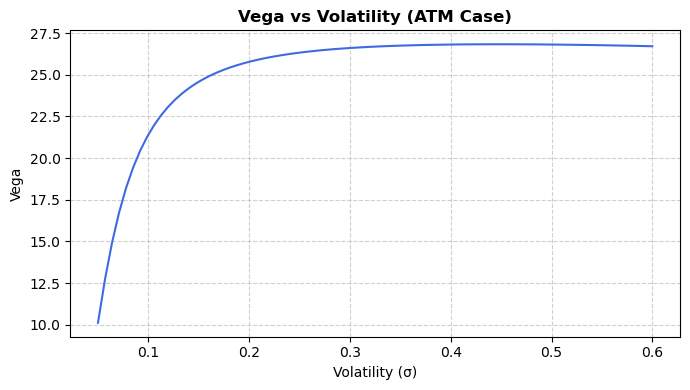

In [9]:
# === VEGA vs VOLATILITY (ATM CASE) ===

sigmas = np.linspace(0.05, 0.6, 80)  # From 5% to 60% vol
K = 100  # ATM strike
S = 100  # Underlying fixed

vegas = [black_scholes_greeks(S, K, T, r, sigma, option='call')["Vega"] for sigma in sigmas]

plt.figure(figsize=(7,4))
plt.plot(sigmas, vegas, color='royalblue')
plt.title("Vega vs Volatility (ATM Case)", fontsize=12, fontweight='bold')
plt.xlabel("Volatility (σ)")
plt.ylabel("Vega")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


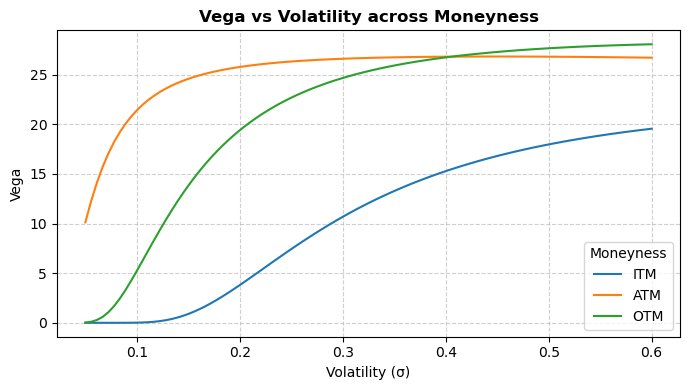

In [10]:
# === VEGA vs VOLATILITY across MONEYNESS ===

sigmas = np.linspace(0.05, 0.6, 100)   # 5% to 60% volatility range

plt.figure(figsize=(7,4))

S = 100  # current underlying price fixed
scenarios = {
    "ITM": {"K": 80},
    "ATM": {"K": 100},
    "OTM": {"K": 120}
}

for label, params in scenarios.items():
    K = params["K"]
    vegas = [black_scholes_greeks(S, K, T, r, sigma, option='call')["Vega"]
             for sigma in sigmas]
    plt.plot(sigmas, vegas, label=label)

plt.title("Vega vs Volatility across Moneyness", fontsize=12, fontweight="bold")
plt.xlabel("Volatility (σ)")
plt.ylabel("Vega")
plt.legend(title="Moneyness")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


**Interpretation:**  
Vega captures the sensitivity of the option’s price to changes in volatility.  
It is highest for at-the-money options because uncertainty about ending up ITM or OTM is greatest — volatility changes the probability mass most effectively.  

Deep ITM and OTM options have low Vega: their payoff is almost fixed regardless of volatility.  
Vega increases with time to expiration, as there is more time for volatility to influence possible outcomes.

In practice, traders focus on **Vega exposure** to gauge how much their portfolio value will shift when implied volatility changes by 1%.  
The bell-shaped curve across moneyness is the foundation of **volatility smile analysis**.


### Vega vs Time to Maturity (ATM Option)

Vega also depends on the time to expiration (T).  
Longer-dated options have higher Vega because volatility has more time to affect the distribution of possible outcomes.  
As the option approaches maturity, Vega decays towards zero — short-dated options are less sensitive to volatility changes.


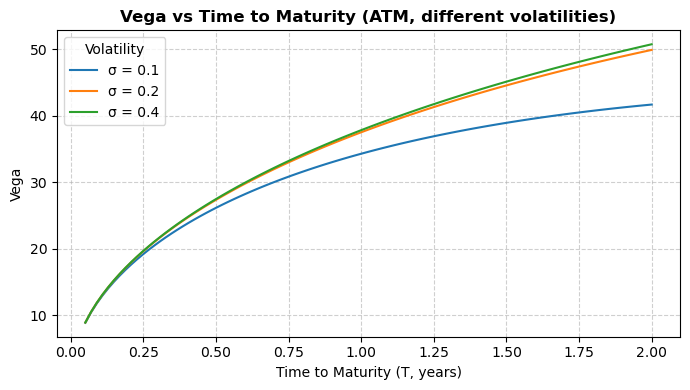

In [12]:
vol_levels = [0.1, 0.2, 0.4]

plt.figure(figsize=(7,4))
for sig in vol_levels:
    vegas = [black_scholes_greeks(S, K, T, r, sig, option='call')["Vega"]
             for T in T_range]
    plt.plot(T_range, vegas, label=f"σ = {sig:.1f}")

plt.title("Vega vs Time to Maturity (ATM, different volatilities)", fontsize=12, fontweight="bold")
plt.xlabel("Time to Maturity (T, years)")
plt.ylabel("Vega")
plt.legend(title="Volatility")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


## Interpretation:
Vega rises with time to maturity because the longer the option lasts, the more opportunity there is for volatility to impact its expected payoff.
Short-dated options (low T) are nearly insensitive to volatility — their outcome is almost determined.
As T increases, uncertainty expands, and Vega climbs sharply before flattening as time effects saturate.

From a trading perspective, this means:

Long-dated options carry higher Vega risk — they are more sensitive to implied volatility changes.
Short-dated options are dominated by Theta decay and have minimal volatility exposure.
This relationship is fundamental in volatility trading and risk management — long maturity positions are the core of Vega exposure in option portfolios

### Theta vs Time to Maturity across Moneyness

Theta measures the sensitivity of the option price to the passage of time.  
It represents how much value an option loses each day as it approaches expiration — known as *time decay*.  
Call options have negative Theta, meaning they lose value as time passes, since the probability of large favorable movements decreases.  
This effect is strongest for at-the-money options and weaker for deep in- or out-of-the-money options.


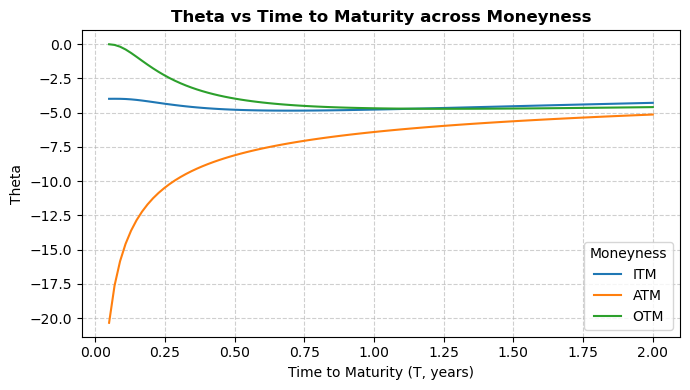

In [13]:
# === THETA vs TIME TO MATURITY across MONEYNESS ===

T_range = np.linspace(0.05, 2.0, 100)   # 0.05 to 2 years
S = 100
sigma = 0.2
r = 0.05

scenarios = {
    "ITM": {"K": 80},
    "ATM": {"K": 100},
    "OTM": {"K": 120}
}

plt.figure(figsize=(7,4))

for label, params in scenarios.items():
    K = params["K"]
    thetas = [black_scholes_greeks(S, K, T, r, sigma, option='call')["Theta"]
              for T in T_range]
    plt.plot(T_range, thetas, label=label)

plt.title("Theta vs Time to Maturity across Moneyness", fontsize=12, fontweight="bold")
plt.xlabel("Time to Maturity (T, years)")
plt.ylabel("Theta")
plt.legend(title="Moneyness")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


**Interpretation:**  
Theta is negative for call options — as time passes, the option’s time value erodes.  
The effect is strongest for at-the-money options, where uncertainty about finishing in or out of the money is highest.  
Deep in- and out-of-the-money options already have relatively certain outcomes, so their Theta is small.

As maturity approaches (T → 0), all Thetas converge toward zero — there is no remaining time value to lose.  

From a trading perspective, Theta represents **the cost of holding optionality**:  
- Short option positions *benefit* from time decay (positive Theta).  
- Long option positions *lose* value every day (negative Theta).  
This trade-off is fundamental in volatility and gamma scalping strategies.


## Summary & Insights

This notebook implemented the Black–Scholes–Merton model and analyzed the main Greeks — Delta, Gamma, Vega, Theta, and Rho — to illustrate how option prices respond to changes in key market variables.

### Key Takeaways

- **Delta** quantifies the directional exposure of an option.  
  It increases from 0 to 1 as the option becomes more in-the-money, representing the hedge ratio of a long call position.

- **Gamma** measures the convexity of the price curve — how fast Delta changes.  
  It peaks at-the-money, where the option’s exposure to small price moves is most unstable and hedging is most demanding.

- **Vega** captures the sensitivity to volatility.  
  It is highest for at-the-money options and grows with time to maturity, making long-dated options the core of Vega exposure in portfolios.

- **Theta** reflects time decay.  
  It is negative for calls, showing the daily erosion of option value.  
  The decay is strongest for at-the-money options and becomes milder for ITM or OTM positions.

- **Rho** measures interest rate sensitivity.  
  It is positive for calls and negative for puts, with higher impact on long-dated contracts.  
  Though less relevant in short-dated equity options, it matters in fixed-income and FX markets.

### Conceptual Insights

- Each Greek isolates a dimension of option risk: **directional (Δ, Γ)**, **volatility (Vega)**, **time (Theta)**, and **rates (Rho)**.  
- Together, they form the foundation of **risk decomposition and hedging** in derivatives portfolios.  
- The combined Delta–Gamma plot visually shows why options introduce non-linear exposures that cannot be hedged with static linear instruments.  

### Professional Implication

Understanding the behavior and interactions of the Greeks allows traders, quants, and portfolio managers to:
- Construct **Delta- and Gamma-neutral portfolios**,  
- Manage **volatility exposure (Vega)**,  
- Optimize **carry and time-decay positions (Theta)**, and  
- Assess **interest-rate sensitivity (Rho)** in multi-asset contexts.

In short, this notebook bridges **theory, computation, and intuition** — translating the mathematics of Black–Scholes into the visual and practical language of risk management.
